# 03F. Separatrix

### Mingyang Lu

### 1/5/2024

## Vector field

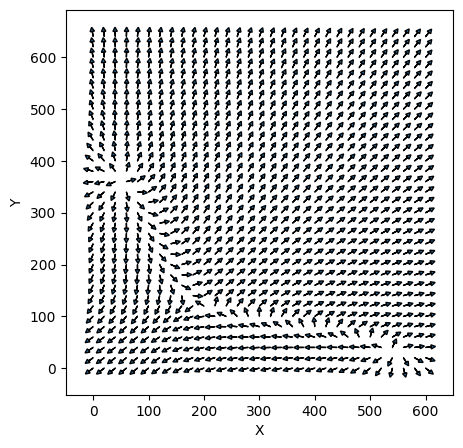

In [1]:
import numpy as np
import matplotlib.pyplot as plt

def hill_inh(X, X_th, n):
    # inhibitory Hill function
    # X_th: Hill threshold, n: Hill coefficient
    a = (X / X_th)**n
    return 1 / (1 + a)

def derivs_ts_revised(t, Xs):
    # Calculate derivative function for a toggle switch circuit
    X = Xs[0]
    Y = Xs[1]
    dxdt = -(5 + 50 * hill_inh(Y, 100, 4) - 0.1 * X)
    dydt = -(4 + 40 * hill_inh(X, 150, 4) - 0.12 * Y)
    return [dxdt, dydt]

X_all = np.arange(0, 601, 20)  # all X grids
Y_all = np.arange(0, 651, 20)  # all Y grids
XY_all = np.array(np.meshgrid(X_all, Y_all)).T.reshape(-1, 2)  # all combinations of X and Y

def generate_normalized_vector_field(Xs):
    X, Y = Xs
    dX, dY = derivs_ts_revised(0, Xs)
    dX_norm = dX/np.sqrt(dX**2 + dY**2)
    dY_norm = dY/np.sqrt(dX**2 + dY**2)
    return [X, Y, 10*dX_norm, 10*dY_norm]

results_unit = np.apply_along_axis(generate_normalized_vector_field, 1, XY_all)

plt.figure(figsize=(5, 5))
for i in range(len(results_unit)):
    plt.arrow(results_unit[i, 0], results_unit[i, 1], results_unit[i, 2], results_unit[i, 3],
              head_width=8, head_length=8, ec='black')

plt.xlabel("X")
plt.ylabel("Y")
plt.show()

## Simulation to obtain separatrix

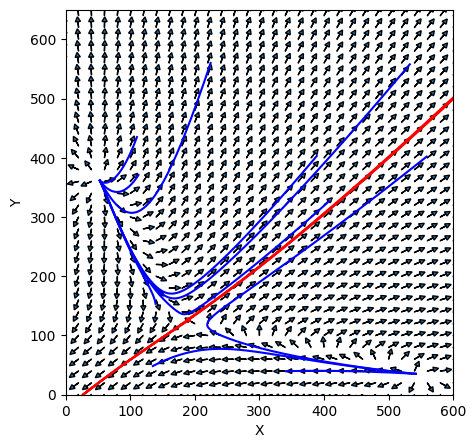

In [2]:
# 4th order Runge-Kutta (RK4) for a generic multi-variable system
def RK4_generic(derivs, X0, t_total, dt, **kwargs):
    # derivs: the function of the derivatives
    # X0: initial condition, a list of multiple variables
    # t_total: total simulation time, assuming t starts from 0 at the beginning
    # dt: time step size
    t_all = np.arange(0, t_total + dt, dt)
    n_all = len(t_all)
    nx = len(X0)
    X_all = np.zeros((n_all, nx))
    X_all[0, :] = X0
    for i in range(n_all - 1):
        t_0 = t_all[i]
        t_0_5 = t_0 + 0.5 * dt
        t_1 = t_0 + dt
        k1 = dt * np.array(derivs(t_0, X_all[i, :], **kwargs))
        k2 = dt * np.array(derivs(t_0_5, X_all[i, :] + k1 / 2, **kwargs))
        k3 = dt * np.array(derivs(t_0_5, X_all[i, :] + k2 / 2, **kwargs))
        k4 = dt * np.array(derivs(t_1, X_all[i, :] + k3, **kwargs))
        X_all[i + 1, :] = X_all[i, :] + (k1 + 2 * k2 + 2 * k3 + k4) / 6
    return np.column_stack((t_all, X_all))

# Deriviative function of the original system
def derivs_ts_orig(t, Xs):
    X, Y = Xs[0], Xs[1]
    dxdt = 5 + 50 * hill_inh(Y, 100, 4) - 0.1 * X
    dydt = 4 + 40 * hill_inh(X, 150, 4) - 0.12 * Y
    return np.array([dxdt, dydt])

# Vector field
plt.figure(figsize=(5, 5))
for i in range(len(results_unit)):
    plt.arrow(results_unit[i, 0], results_unit[i, 1], results_unit[i, 2], results_unit[i, 3],
              head_width=8, head_length=8, ec='black')

np.random.seed(75)  # Set the seed for the random number generator
t_total = 100
dt = 0.01
X_range = [0, 600]
Y_range = [0, 650]

# Simulations of the original system
X_init_1 = np.random.uniform(0, 600, size=(10, 2))
for i in range(X_init_1.shape[0]):
    results = RK4_generic(derivs_ts_orig, X_init_1[i, :], t_total, dt)
    plt.plot(results[:, 1], results[:, 2], color='blue')

# Simulation to find separatrix
X_init_2 = np.random.uniform(-2, 2, size=(10, 2))
X_init_2[:, 0] += 189.96888
X_init_2[:, 1] += 126.64398
for i in range(X_init_2.shape[0]):
    results = RK4_generic(derivs_ts_revised, X_init_2[i,:], t_total, dt)
    results = results[
        np.where(
            ((results[:, 1] - X_range[0]) * (results[:, 1] - X_range[1]) < 0)
            & ((results[:, 2] - Y_range[0]) * (results[:, 2] - Y_range[1]) < 0)
        )
    ]
    plt.plot(results[:, 1], results[:, 2], color='red')

plt.xlabel("X")
plt.ylabel("Y")
plt.xlim(0, 600)
plt.ylim(0, 650)
plt.show()